# "Training in FP16"
> "Here we find that there are many things to consider when using fp16 training. Normalization, and batch size become important to avoid gradient overflow.  "

- toc:true
- branch: master
- badges: true
- comments: true
- author: Molly Beavers
- categories: [UGATIT,FP16,GAN,Image Generation,Image to Image]

In [13]:
ModelToHalf??

In [1]:
from nbdev import export2html

In [2]:
from nbdev import export2html
from fastai2.basics import *
from fastai2.vision.all import *

In [3]:
torch.cuda.set_device(torch.device(1))

In [4]:
path=untar_data(URLs.IMAGENETTE)

In [5]:
db=DataBlock((ImageBlock, CategoryBlock), get_items=get_image_files, splitter=GrandparentSplitter(valid_name='val'),
                   get_y=parent_label,item_tfms=Resize(460),batch_tfms=aug_transforms(do_flip=False,size=224,min_scale=0.75))

In [6]:
dls=db.dataloaders(path)

## FP32 Training

In [6]:
learner=cnn_learner(dls,resnet50,pretrained=False)

(0.003981071710586548, 3.6307804407442745e-07)

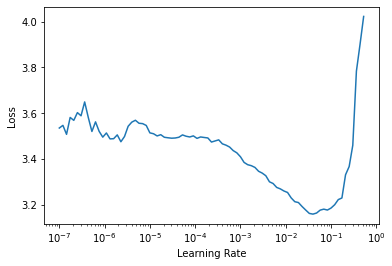

In [7]:
learner.lr_find()

In [ ]:
learner.fit_one_cycle(20,lr_max=0.004)

epoch,train_loss,valid_loss,time
0,2.587429,2.266000,01:25
1,2.096462,2.123229,01:26
2,1.828060,1.951162,01:27
3,1.648421,5.487250,01:26
4,1.668218,76.065506,01:27
5,1.445840,7.656888,01:27
6,1.359991,4.267499,01:27
7,1.241733,2.489847,01:27
8,1.185173,2.059126,01:27
9,1.004659,1.420557,01:27


In [ ]:
learner.recorder.plot_loss(skip_start=20)

## FP16

In [7]:
class MixedPrecision(Callback):
    "Run training in mixed precision"
    run_before = Recorder

    def __init__(self):
        assert torch.backends.cudnn.enabled, "Mixed precision training requires cudnn."

    def begin_batch(self): self.learn.xb = to_half(self.xb)
    def after_batch(self): self.learn.loss = to_float(self.learn.loss)

epoch,train_loss,valid_loss,time
0,2.629170,2.088107,01:03
1,2.177353,1.734887,00:58
2,1.867289,2.584038,01:00
3,1.889801,2.206467,00:56
4,1.808237,2.857419,00:56
5,1.543076,1.435042,00:56
6,1.383324,2.250526,00:56
7,1.568063,nan,00:56
8,1.512297,6.973746,00:56
9,1.295254,1.013582,00:57


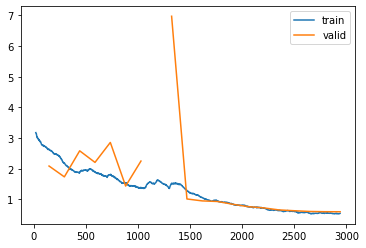

In [8]:
learner=cnn_learner(dls,resnet50,pretrained=False)
learner.add_cbs((ModelToHalf(),MixedPrecision()))
learner.fit_one_cycle(20,lr_max=0.004)
learner.recorder.plot_loss(skip_start=20)

## Training in FP16 with loss scale

epoch,train_loss,valid_loss,time
0,2.658888,2.297445,01:16
1,2.236564,1.773352,01:19
2,1.778565,1.774128,01:18
3,1.685369,114.709724,01:17
4,1.777819,518.991150,01:16
5,1.502959,2.784401,01:20
6,1.352746,3.021359,01:16
7,1.255820,3.930870,01:12
8,1.157199,1.359756,01:08
9,1.097680,1.390226,01:08


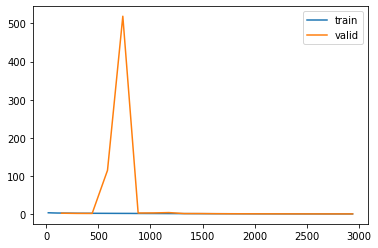

In [7]:
learner=cnn_learner(dls,resnet50,pretrained=False)
learner.to_fp16()
learner.fit_one_cycle(20,lr_max=0.004)
learner.recorder.plot_loss(skip_start=20)

Reduced range in fp16⁴. Insert Image

As seen about there is a limited range to fp16. fp16 overflow is when your gradients are too big too fit within fp16. Underflow is when fp16 gradients are so close to 0 that they are simply rounded to 0. Overflow and underflow can happen in fp32 as well, but isn't nearly as big of a problem because fp32 is able to "hold" more information. Loss scaling is multiplying our loss by as large a value as possible,which effectively is multiplied by our gradients to keep them within its representable range. This avoids underflow by increasing the gradients, but we need to make sure it is not big enough that it causes an overflow. One technicality to loss scaling is calculating the loss itself in fp32, because calculating a loss includes division and low precision division is very in-precise leading to unstable gradients/training. Another technicality is that the gradients have to be divided by the loss scale, to keep the magnitudes consistent with a fp32-bit model, otherwise this would be very similar to simply increasing the learning rate by the loss scale! But, wait a minute… if we divide by the loss scale won't we just run into the underflow issue from before? Your right, we have to have a fp32 copy of the weights as well, so that we can avoid this problem. We copy the scaled gradients over to an fp32 model and then divide by the loss scale there. We then continue the optimization step in fp32.

## Batch Size

Batch size is imporant in fp16 training. I found that, the very first convolution layer was very unstable in my training. Increasing the batch size tends to smooth out this first layer's gradients as there are more inputs to the layer. 

## 2-category Categorical Cross Entropy VS Binary Cross Entropy with Logits

For people not overly familiar with loss functions, Categorical Cross Entropy is the loss function generally used for selecting a single category, out of many. Examples of tasks that use Categorical Cross Entropy are Imagenet Classification or Dog vs Cat. Dog vs Cat is a special case, because there are only two choices, Dog or Cat, this is what I am referring to when I say 2-category Categorical Cross Entropy. Binary Cross Entropy with Logits is very similar, but uses a Sigmoid into a Binary Cross Entropy Loss, which is calculating loss based on distance from either 0 or 1. This means that Categorical Cross Entropy requires 2 values one for each category, and Binary cross entropy calculates loss based on one value ranging from 0 to 1. In order to avoid overflow, I wanted to be able to raise weight decay to the largest value possible, well Binary Cross Entropy works by sending values through a Sigmoid and then seeing if the value is close to 1, but weight decay pushes these values to 0, which after going through Sigmoid equals 0.5. So, instead I decided to use loss that used Softmax instead. This allows small values to be "highly confident", because if you have two small values (0.0099,0.00001) you can still get large numbers to send into the loss calculation (0.0099/(0.0099+0.00001)).

## Limiting Maximum Loss and Differential Loss Functions

I found that is was very important to effectively cap the maximum loss and minimum loss. This becaomes a problem if your model is expected to have very large loss values such as values greater than a magnitude of 100. Generally the loss is positive and relatively small, though in the case of Wasserstein (https://arxiv.org/abs/1506.05439) loss the loss can take a negative value. For large maximal values I found that differential losses can be very large, especially if your loss functions look something like (1000 x loss1 + loss2). In the case of differential loss functions, I found that I was able to get satisfactory results simply by changing the function to 1000 x tanh(loss1)+loss2. I expect gradient clipping would also be very helpful, but I have not yet experimented with that myself. 

## Normalization

In my experience I found normalization to be very important in making sure an architecture performed well in fp16 training. Some architectures with very little normalization I had constant issues with overflowing or underflowing gradients. Introducing Similar normalization layers to those already present in the model gave me similar results to the fp32 models. 

## Contact Me

I am looking for a Job

Linked-In Profile: https://www.linkedin.com/in/molly-beavers-651025118/
Source Code(WIP): https://github.com/marii-moe/selfie2anime

## References 

[1] Junho Kim, Minjae Kim, Hyeonwoo Kang and Kwang Hee Lee. U-GAT-IT: Unsupervised Generative Attentional Networks with Adaptive Layer-Instance Normalization for Image-to-Image Translation. International Conference on Learning Representations. 2020 https://openreview.net/forum?id=BJlZ5ySKPH
[2] Jun-Yan Zhu*, Taesung Park*, Phillip Isola, and Alexei A. Efros. "Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks", in IEEE International Conference on Computer Vision (ICCV), 2017. (* indicates equal contributions). https://arxiv.org/pdf/1703.10593.pdf
[3] Ian J. Goodfellow, Jean Pouget-Abadie, Mehdi Mirza, Bing Xu, David Warde-Farley, Sherjil Ozair, Aaron Courville, Yoshua Bengio."Generative Adversarial Networks." ArXiv, 2014. https://arxiv.org/abs/1406.2661
[4] Micikevicius, P., Narang, S., Alben, J., Diamos, G.F., Elsen, E., García, D., Ginsburg, B., Houston, M., Kuchaiev, O., Venkatesh, G., & Wu, H."Mixed Precision Training". ArXiv, 2017. https://arxiv.org/abs/1710.03740
[5] Chen, T., Xu, B., Zhang, C., & Guestrin, C. "Training Deep Nets with Sublinear Memory Cost". ArXiv, 2016. https://arxiv.org/abs/1604.06174
[6] Jason Antic. "DeOldify". https://github.com/jantic/DeOldify
[7] Hicsonmez, Samet & Samet, Nermin & Akbas, Emre & Duygulu, Pinar. "GANILLA: Generative adversarial networks for image to illustration translation". Elsevier Image and Vision Computing 103886, 2020. https://arxiv.org/abs/2002.05638
[8] Zhou, B. & Khosla, A. and Lapedriza. A. and Oliva, A. and Torralba, A. "Learning Deep Features for Discriminative Localization." CVPR, 2016. http://cnnlocalization.csail.mit.edu/
[9] Howard, J., & Gugger, S. fastai: A Layered API for Deep Learning. ArXiv, 2020. https://arxiv.org/abs/2002.04688
[10] Biewald, Lukas. "Experiment Tracking with Weights and Biases". 2020. https://www.wandb.com/

In [ ]:
export2html.notebook2html(fname='Blog_Post.ipynb', dest='html/', template_file='fastpages.tpl',n_workers=1)